Ячейка 1. Импорт и загрузка

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import xgboost as xgb
from sklearn.metrics import roc_auc_score, classification_report

# Визуализация результатов
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (6,4)

# Загрузка датафрейма
df = pd.read_csv("../data/processed/df_clean.csv")
df['readmit_bin'] = (df['readmitted'] == '<30').astype(int)

# Сплит
features = [
    'time_in_hospital','age_num','num_lab_procedures','num_procedures',
    'num_medications','number_outpatient','number_emergency',
    'number_inpatient','number_diagnoses',
    'race','gender','admission_type_id','discharge_disposition_id',
    'admission_source_id','payer_code','medical_specialty','change','diabetesMed'
]
X = df[features]
y = df['readmit_bin']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

 Ячейка 2. Конвейер обработки признаков и сетка гиперпараметров


In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Числовые и категориальные признаки
num_feats = [
    'time_in_hospital','age_num','num_lab_procedures','num_procedures',
    'num_medications','number_outpatient','number_emergency',
    'number_inpatient','number_diagnoses'
]
cat_feats = [
    'race','gender','admission_type_id','discharge_disposition_id',
    'admission_source_id','payer_code','medical_specialty','change','diabetesMed'
]

# Препроцессор
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_feats),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_feats),
])

# Pipeline без use_label_encoder
pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", xgb.XGBClassifier(eval_metric="auc", random_state=42))
])

# Сетка гиперпараметров
param_dist = {
    "clf__n_estimators":     [50, 100, 200, 300],
    "clf__max_depth":        [3, 5, 7, 9],
    "clf__learning_rate":    [0.01, 0.05, 0.1, 0.2],
    "clf__subsample":        [0.6, 0.8, 1.0],
    "clf__colsample_bytree": [0.6, 0.8, 1.0],
    "clf__gamma":            [0, 1, 5],
    "clf__scale_pos_weight": [(y_train == 0).sum() / (y_train == 1).sum()],
}

# Инициализация RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=30,
    scoring="roc_auc",
    cv=3,
    verbose=2,
    n_jobs= - 1,
    random_state=42
)


Ячейка 3. Запуск поиска и оценка

In [ ]:
# Запускаем
search.fit(X_train, y_train)

# Лучшие параметры и AUC
print("Best params:", search.best_params_)
best_auc = search.best_score_
print(f"Best CV ROC AUC: {best_auc:.3f}")

# Оценка на тесте
y_proba = search.predict_proba(X_test)[:,1]
test_auc = roc_auc_score(y_test, y_proba)
print(f"Test ROC AUC: {test_auc:.3f}")

# Если нужно  - выводим classification_report
y_pred = search.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['No (<30)','Yes (<30)']))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params: {'clf__subsample': 0.6, 'clf__scale_pos_weight': np.float64(7.960503144654088), 'clf__n_estimators': 300, 'clf__max_depth': 3, 'clf__learning_rate': 0.1, 'clf__gamma': 1, 'clf__colsample_bytree': 0.6}
Best CV ROC AUC: 0.673
Test ROC AUC: 0.682
              precision    recall  f1-score   support

    No (<30)       0.93      0.66      0.77     27123
   Yes (<30)       0.18      0.60      0.28      3407

    accuracy                           0.65     30530
   macro avg       0.56      0.63      0.53     30530
weighted avg       0.85      0.65      0.72     30530



 Ячейка 4. Feature Engineering

Перед обучением модели мы расширяем пространство признаков, чтобы помочь алгоритму уловить скрытые зависимости:

- **Группируем диагнозы** по первым трём символам и кодируем их целевым энкодингом, отражая связь конкретных категорий с повторной госпитализацией.  
- **Частотное кодирование** для `medical_specialty` позволяет сохранить лишь самые распространённые специальности и объединить редкие в «Other».  
- **Взаимодействия числовых признаков** (например, `time_in_hospital * num_medications`, `age_num * number_diagnoses`) помогают модели учесть сложные комбинированные эффекты.  

Эти приёмы обычно повышают выразительность признакового пространства и улучшают качество предсказаний.  


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# 1) Frequency Encoding для топ - 10 medical_specialty
top10 = df['medical_specialty'].value_counts().nlargest(10).index
df['med_spec_grp'] = df['medical_specialty'].where(df['medical_specialty'].isin(top10), 'Other')
freq = df['med_spec_grp'].value_counts(normalize=True)
df['med_spec_freq'] = df['med_spec_grp'].map(freq)

# 2) Простейший target - encoding для diag_1[:3]
df['diag1_cat'] = df['diag_1'].str[:3]
# средний таргет по группе
diag_mean = df.groupby('diag1_cat')['readmit_bin'].mean()
df['diag1_te'] = df['diag1_cat'].map(diag_mean)

# 3) Попарные взаимодействия числовых признаков
num_feats = [
    'time_in_hospital','age_num','num_lab_procedures','num_procedures',
    'num_medications','number_outpatient','number_emergency',
    'number_inpatient','number_diagnoses'
]
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_arr = poly.fit_transform(df[num_feats])
poly_cols = poly.get_feature_names_out(num_feats)
df_poly = pd.DataFrame(poly_arr, columns=poly_cols, index=df.index)

# Оставляем только новые взаимодействия
interact_cols = [c for c in poly_cols if '*' in c]
df_poly = df_poly[interact_cols]

# Объединяем с основным DF
df = pd.concat([df, df_poly], axis=1)

# Удаляем промежуточные колонки
df.drop(columns=['medical_specialty','med_spec_grp','diag_1','diag1_cat'], inplace=True)

# Контроль
print("Всего признаков после FE:", df.shape[1])

Всего признаков после FE: 46


Ячейка 5. Разделение и стандартизация

In [6]:
# 1) Формируем X и y
drop_cols = ['readmitted', 'diag_2', 'diag_3']
X = df.drop(columns=drop_cols + ['readmit_bin'])
y = df['readmit_bin']

# 2) Разбиваем выборку
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# 3) Стандартизация числовых фичей
from sklearn.preprocessing import StandardScaler

num_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])

print("Числовые признаки стандартизированы:", num_cols)

Train shape: (71236, 42), Test shape: (30530, 42)
Числовые признаки стандартизированы: ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'age_num', 'med_spec_freq', 'diag1_te']


Ячейка 6. Переобучение моделей и сравнение

In [8]:
# Ячейка 6. LogisticRegression с ColumnTransformer

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

# 1) Определяем числовые и категориальные фичи
num_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

# 2) Строим препроцессор
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
])

# 3) Собираем Pipeline и обучаем
pipe_lr = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])
pipe_lr.fit(X_train, y_train)

# 4) Оцениваем качество
proba_lr = pipe_lr.predict_proba(X_test)[:,1]
pred_lr  = pipe_lr.predict(X_test)
print("LogisticRegression ROC AUC:", round(roc_auc_score(y_test, proba_lr),3))
print(classification_report(y_test, pred_lr, target_names=['No (<30)','Yes (<30)']))

LogisticRegression ROC AUC: 0.66
              precision    recall  f1-score   support

    No (<30)       0.92      0.67      0.77     27123
   Yes (<30)       0.17      0.55      0.26      3407

    accuracy                           0.65     30530
   macro avg       0.55      0.61      0.52     30530
weighted avg       0.84      0.65      0.72     30530



Ячейка 7. XGBoost через ColumnTransformer

In [9]:
from xgboost import XGBClassifier

pipe_xgb = Pipeline([
    ("prep", preprocessor),
    ("clf", XGBClassifier(
        eval_metric="auc", random_state=42,
        scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
        n_estimators=300, max_depth=3, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.6, gamma=1
    ))
])
pipe_xgb.fit(X_train, y_train)

proba_xgb = pipe_xgb.predict_proba(X_test)[:,1]
pred_xgb  = pipe_xgb.predict(X_test)
print("XGBoost ROC AUC:", round(roc_auc_score(y_test, proba_xgb),3))
print(classification_report(y_test, pred_xgb, target_names=['No (<30)','Yes (<30)']))

XGBoost ROC AUC: 0.69
              precision    recall  f1-score   support

    No (<30)       0.93      0.66      0.77     27123
   Yes (<30)       0.18      0.62      0.28      3407

    accuracy                           0.65     30530
   macro avg       0.56      0.64      0.53     30530
weighted avg       0.85      0.65      0.72     30530



Ячейка 8. Сравнение моделей и матрица ошибок

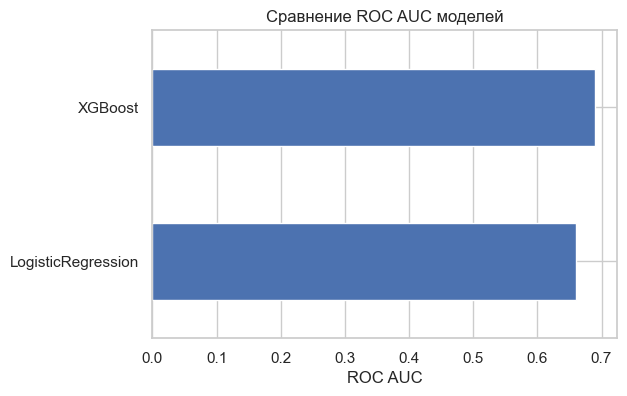

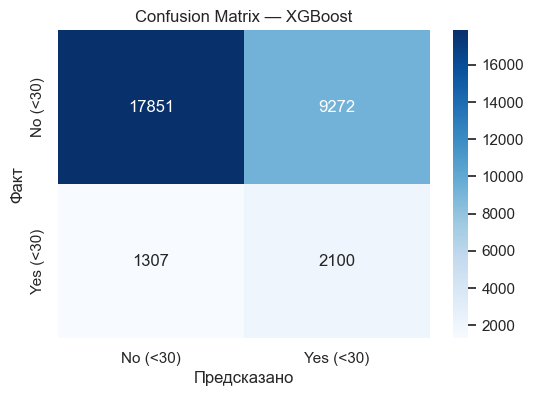

In [ ]:
# 8.1) Сравнение ROC AUC
results = pd.Series({
    'LogisticRegression': roc_auc_score(y_test, proba_lr),
    'XGBoost':            roc_auc_score(y_test, proba_xgb)
})
results.plot(
    kind='barh',
    title="Сравнение ROC AUC моделей",
    xlabel="ROC AUC"
)
plt.show()

# 8.2) Confusion matrix для XGBoost
cm = confusion_matrix(y_test, pred_xgb)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['No (<30)', 'Yes (<30)'],
    yticklabels=['No (<30)', 'Yes (<30)']
)
plt.title("Confusion Matrix  - XGBoost")
plt.xlabel("Предсказано")
plt.ylabel("Факт")
plt.show()